In [7]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('MTA_Subway_Ridership_Data_Clean.csv')
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.set_index("Date", inplace=True)
df.rename(columns={
    "Subways: Total Estimated Ridership" : "Total Ridership",
    "Subways: % of Comparable Pre-Pandemic Day" : "Pre-Pandemic Ridership"
}, inplace=True)

Apply **min-max** scaling to normalize the dataset

In [102]:
df['Total Ridership Standardized'] = (df['Total Ridership'] - df['Total Ridership'].mean()) / df['Total Ridership'].std()

In [103]:
df.head()

,Total Ridership,Pre-Pandemic Ridership,Total Ridership Standardized
Date,,,
2020-03-01,2212965,0.97,-0.308030
2020-03-02,5329915,0.96,2.611445
2020-03-03,5481103,0.98,2.753054
2020-03-04,5498809,0.99,2.769638
2020-03-05,5496453,0.99,2.767431


In [104]:
original_y = df['Total Ridership Standardized'].values.astype(float)

In [105]:
N = 1 << (len(y) - 1).bit_length()
norm = np.linalg.norm(original_y)
y = np.pad(original_y, (0, N - len(original_y)), mode='constant')
y = y / norm
n_qubits = int(np.ceil(np.log2(N)))

In [106]:
print(f"Number of qubits: {n_qubits}")

Number of qubits: 11


In [107]:
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

Implement the **Quantum Fourier Transform** circuit

In [108]:
def QFT(wires):
    N = len(wires)
    for i in range(N):
        qml.Hadamard(wires=i)
        for j in range(i+1, N):
            qml.ControlledPhaseShift(np.pi/2**(j-i), wires=[j, i])
    for i in range(N//2):
        qml.SWAP(wires=[i, N-1-i])

In [109]:
@qml.qnode(dev)
def getAmplitude(K):
    qml.StatePrep(y, wires=range(n_qubits), normalize=True)
    QFT(range(n_qubits))
    state = qml.state()
    return state

In [110]:
def getCoeff(K):
    alpha = getAmplitude(K).tolist()[K]
    X = alpha * norm * np.sqrt(N)
    a = 2 / N * np.real(X)
    b = -2 / N * np.imag(X)
    return a, b

In [111]:
def periodToBin(period, N):
    return round(N / period)

In [112]:
weekly_bin, yearly_bin = periodToBin(7, N), periodToBin(365, N)
print(f"Weekly bin: {weekly_bin}, Yearly bin: {yearly_bin}")

Weekly bin: 293, Yearly bin: 6


In [113]:
a_weekly, b_weekly = getCoeff(weekly_bin)
a_yearly, b_yearly = getCoeff(yearly_bin)
print(f"Weekly coefficients: a={a_weekly}, b={b_weekly}")
print(f"Yearly coefficients: a={a_yearly}, b={b_yearly}")

Weekly coefficients: a=-0.22224364755721737, b=0.4166695251903953
Yearly coefficients: a=0.036850315215633214, b=0.14638888553811857


In [114]:
def reconstructSeason(a, b, N, L):
    t = np.arange(N)
    S = a * np.cos(2 * np.pi * t / L) + b * np.sin(2 * np.pi * t / L)
    return S

In [115]:
weekly_curve = reconstructSeason(a_weekly, b_weekly, N, 7)       # weekly period = 7
yearly_curve = reconstructSeason(a_yearly, b_yearly, N, 365)     # yearly period = 365
seasonal_curve = weekly_curve + yearly_curve

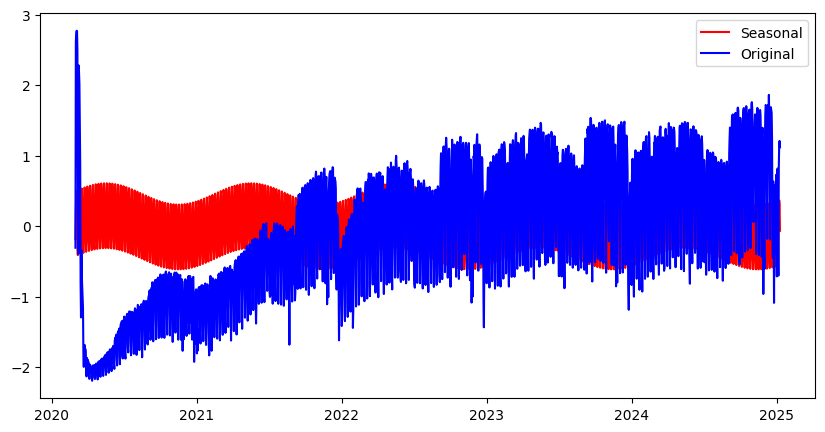

In [116]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, seasonal_curve[:len(df)], label='Seasonal', color='red')
plt.plot(df.index, df['Total Ridership Standardized'], label='Original', color='blue')
plt.legend()
plt.show()